In [1]:
#Append path to Ruomin's Edamame Package (Nanowire Simulations)
import sys
sys.path.append('/import/silo2/aloe8475/Documents/edamame')

In [2]:
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from numpy import linalg
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.lines as mlines
from matplotlib import colors
import pandas as pd
import skspatial
from skspatial.objects import Plane, Points
from skspatial.plotting import plot_3d


from scipy.io import loadmat, savemat
from scipy import signal

#Import Ruomin's package
from edamame import * 


#import networkx for visualisation of networks
import networkx as nx

#tqdm allows for progress bars
from tqdm.notebook import tqdm_notebook as tqdm

import os
from IPython.core.debugger import set_trace
import matplotlib.colors as clrs


In [3]:
#VISUALISE NETWORK STATE
def getWeightedGraph(edgeList,numWires,nwState):#, this_TimeStamp = 0):
#     edgeList = network['edge_list']
    adjMat = np.zeros((numWires, numWires))
#     set_trace()
    adjMat[edgeList[:,0], edgeList[:,1]] = nwState.voltage*nwState.conductance#network.junctionSwitch[this_TimeStamp,:] #CHANGE THIS TO CONDUCTANCE THRESHOLD?
    adjMat[edgeList[:,1], edgeList[:,0]] = nwState.voltage*nwState.conductance#network.junctionSwitch[this_TimeStamp,:] #CHANGE THIS TO CONDUCTANCE THRESHOLD?
    WeightedGraph = nx.from_numpy_array(adjMat)
    WeightedGraph=nx.DiGraph.to_undirected(WeightedGraph)
    
    return WeightedGraph

def draw_network_state(connectivity,nwState):
    adjMat=connectivity.adj_matrix
    graph=nx.from_numpy_array(adjMat)
    OGgraph=graph.copy()
    pos=nx.kamada_kawai_layout(OGgraph)
    numWires=graph.number_of_nodes()
    edgeList=np.array(list(graph.edges()))
    weightedSubGraph=getWeightedGraph(edgeList,numWires,nwState)
    minWeights=1e-7 #currents
    maxWeights=1e-4 #currents
    
    #draw network
    %matplotlib inline
    f,ax=plt.subplots(figsize=(10,6))
    G=weightedSubGraph
    edge_weights=nx.get_edge_attributes(G,'weight')
#     G.remove_edges_from((e for e, w in edge_weights.items() if w <1e-5)) 
    edges=G.edges()
    weights=[G[u][v]['weight'] for u,v in edges]

    #draw OG graph
    pos=nx.kamada_kawai_layout(OGgraph)
    h=nx.draw_networkx_nodes(OGgraph,pos=pos,node_color='grey',node_size=10,ax=ax)
    h.set_zorder(1)

    h2=nx.draw_networkx_edges(G,pos=pos,ax=ax,edge_color=weights,edge_cmap=plt.cm.hot_r,edge_vmin=minWeights,edge_vmax=maxWeights)
#     if h2:
#         h2.set_norm(clrs.SymLogNorm(10))
#         h2.set_zorder(3)
    #             if j == 10 and i == 6:
    #                 plt.colorbar(h2)
    nx.draw_networkx_nodes(G,pos=pos,nodelist=sources,node_color='#3f9b0b',node_size=120,node_shape ='*',ax=ax)
    nx.draw_networkx_nodes(G,pos=pos,nodelist=drain_pool,node_color='r',node_size=120,node_shape ='*',ax=ax)
    plt.colorbar(h2,label='current',ax=ax)
    plt.show()

In [4]:
#Generating Electrode positions in Network - Written by Ruomin Zhu
def genGridNW(xa,xb,ya,yb,ex,ey):
    e = []
    for i in range(len(ex)):
        d = np.zeros(len(xa))
        for j in range(len(xa)):
            d[j]=dist((xa[j], ya[j]), (xb[j], yb[j]), (ex[i], ey[i]))
        e.append(np.argmin(d))
    return np.array(e)

def point_on_line(a, b, p):
    ap = p - a
    ab = b - a
    result = a + np.dot(ap, ab) / np.dot(ab, ab) * ab
    return result

def dist(p1,p2,p3):
    p1=np.array(p1) #xa ya
    p2=np.array(p2) #xb yb
    p3=np.array(p3) # ex ey (electrode placement)
    
    #determine whether closest point to electrode is on the line, or outside the line 
    t=point_on_line(p1,p2,p3)
    if t[1]<p1[1]:
        r = np.linalg.norm(p3-p1) #if point is outside left (xvalues)
    elif t[1] > p2[1]:
        r = np.linalg.norm(p3-p2) #if point is outside right (xvalues)
    else:
        r = np.linalg.norm(np.cross(p2-p1, p1-p3))/np.linalg.norm(p2-p1) #if point is inside xvalues
    return r

In [5]:
#load SPARSE network
#Not you need this file in a folder called Sparse Networks 
# asn_nw_00300_nj_00621_seed_1252_avl_10.00_disp_01.00_lx_100.00_ly_100.00
#
nw=loadmat('../Sparse Networks/asn_nw_00250_nj_00794_seed_134_avl_10.00_disp_01.00_lx_50.00_ly_50.00')
this_seed=8639#np.random.randint(10000) #random seed
Network=nw#edamame.core.generate_network(300,dispersion=350,mean_length=200,this_seed=this_seed)
connectivity=connectivity__(wires_dict=Network) 

In [6]:
#fixing file structure from Matlab:
connectivity.avg_length=connectivity.avg_length[0][0]
connectivity.number_of_junctions=connectivity.number_of_junctions[0][0]
connectivity.centroid_dispersion=connectivity.centroid_dispersion[0][0]
connectivity.dispersion=connectivity.dispersion[0][0]
# connectivity.generating_number_of_wires=connectivity.generating_number_of_wires[0][0]
connectivity.gennorm_shape=connectivity.gennorm_shape[0][0]
connectivity.length_x=connectivity.length_x[0][0]
connectivity.length_y=connectivity.length_y[0][0]
connectivity.number_of_wires=connectivity.number_of_wires[0][0]
connectivity.numOfWires=connectivity.numOfWires[0][0]
connectivity.numOfJunctions=connectivity.numOfJunctions[0][0]
connectivity.theta=connectivity.theta[0][0]
connectivity.this_seed=connectivity.this_seed[0][0]

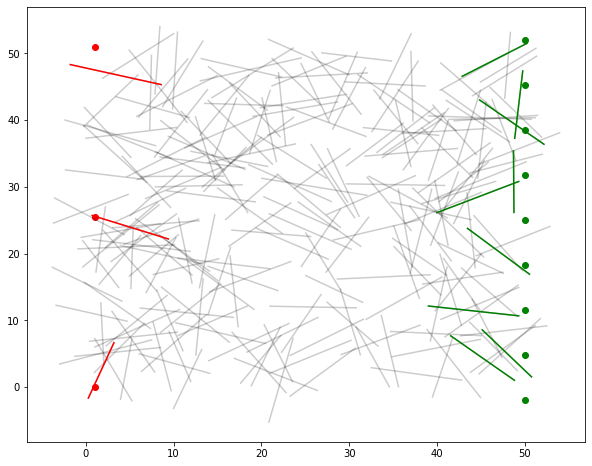

In [7]:
#Generate Network
%matplotlib inline

#find x and y values of each end of each wire 
xa=connectivity.xa[0]
xb=connectivity.xb[0]
ya=connectivity.ya[0]
yb=connectivity.yb[0]

#Pick Electrode placement/distance apart:

#DRAINS
numDrains=3
ex=np.ones(numDrains)*1#*15
# ey=np.linspace(0,550,numDrains)
ey=np.linspace(0,51,numDrains)#(50,100,numDrains)

elecDrain=genGridNW(xa,xb,ya,yb,ex,ey) #generate drain locations in ex, ey coordinates

plt.figure(figsize=(10,8))
plt.scatter(ex, ey, c = 'r')

#SOURCES
numSources=9
ex=np.ones(numSources)*50#95
# ey=np.linspace(0,550,numSources)
ey=np.linspace(-2,52,numSources)#(35,100,numSources)

elecSource=genGridNW(xa,xb,ya,yb,ex,ey) #generate source locations in ex, ey coordinates

plt.plot([xa, xb], [ya, yb], c = 'k',alpha=0.2)
plt.plot([xa[elecDrain], xb[elecDrain]], [ya[elecDrain], yb[elecDrain]], c = 'r')
plt.plot([xa[elecSource], xb[elecSource]], [ya[elecSource], yb[elecSource]], c = 'g')

plt.scatter(ex, ey, c = 'g')

# plt.savefig(figLoc+'Network and Electrodes.png',dpi=300)

In [8]:
sources = elecSource
drain_pool = elecDrain
# allTargets=onehot_outputs
eles=np.append(drain_pool, sources)

In [9]:
currInput=[0,0,0,1,1,1,0,0,0]
dt=1e-3
T=20
onAmp = 0.2
training_stimulus=[]
for i in range(3):
    training_stimulus.append((stimulus__(biasType='Drain',T=T,dt=dt)))

#Sources
for i in range(len(currInput)):
    if currInput[i]==1:
        training_stimulus.append((stimulus__(biasType='DC',onAmp=onAmp,T=T,dt=dt)))
    else:
        training_stimulus.append((stimulus__(biasType='DC',onAmp=0,T=T,dt=dt)))

In [10]:
sim=[]
network_state=[]
avg_filament_state=[]
for i in tqdm(range(10)):
    if i == 0:
        sim.append(runSim(connectivity, stimulus = training_stimulus,
                           junctionMode = 'tunneling',
                           dt = dt, T = T, 
                           contactMode = 'preSet',
                           electrodes = eles,
                           findFirst = False,
                           start_state = None,
                           disable_tqdm=True))
    else:
        sim.append(runSim(connectivity, stimulus = training_stimulus,
                           junctionMode = 'tunneling',
                           dt = dt, T = T, 
                           contactMode = 'preSet',
                           electrodes = eles,
                           findFirst = False,
                           start_state = network_state[i-1],
                           disable_tqdm=True))
        
    network_state.append(getJunctionState(sim[i],-1))
    avg_filament_state.append(np.mean(abs(sim[i].filamentState),axis=1))

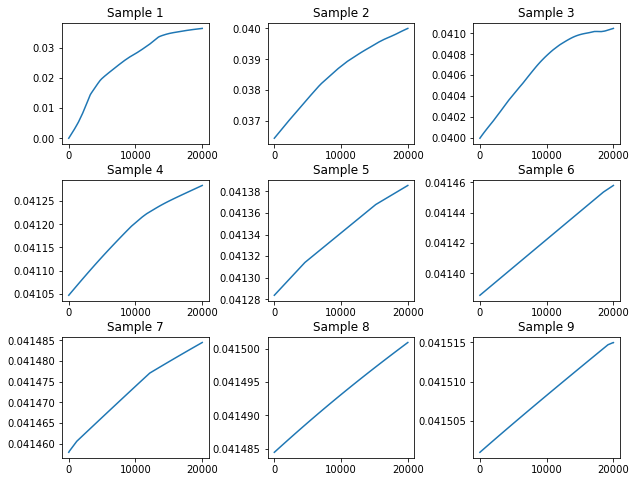

In [11]:
f,axes=plt.subplots(3,3,figsize=(10,8))
f.subplots_adjust(hspace=0.3,wspace=0.4)
i=0
for ax in axes.flat:
    ax.plot(avg_filament_state[i])
#     ax.set_ylim([-0.])
    ax.set_title('Sample '+ str(i+1))
    i+=1

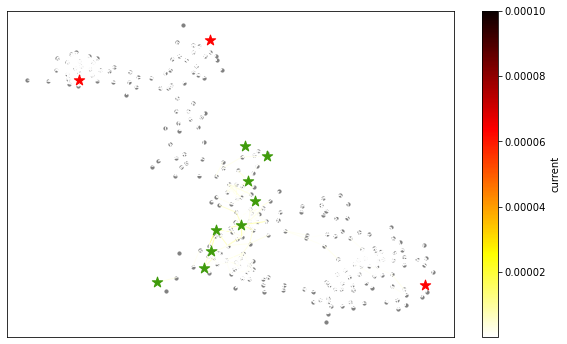

In [12]:
draw_network_state(connectivity,network_state[0])

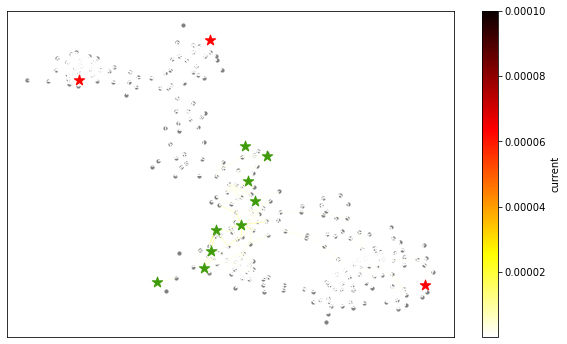

In [13]:
draw_network_state(connectivity,network_state[-1])